# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Данные/bank_fin.zip', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [ ]:
df.info()# info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum() # пропуски

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В данных есть спрятанные пропуски

In [ ]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [ ]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [ ]:
# Обработаем признак 'job'
df['job'] = df['job'].str.replace('unknown', df['job'].mode()[0], regex=True)
# Обработаем признак 'education'
df['education'] = df['education'].str.replace('unknown', df['education'].mode()[0], regex=True)

In [ ]:
# Обработаем признак 'balance' и приведем его к float
df['balance'] = df['balance'].str.replace('$', '', regex=True)
df['balance'] = df['balance'].str.replace(' ', '', regex=True)
df['balance'] = df['balance'].str.replace(',', '.', regex=True).astype('float')

(array([8.653e+03, 2.291e+03, 1.360e+02, 3.700e+01, 1.200e+01, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-6847. ,  1958.1, 10763.2, 19568.3, 28373.4, 37178.5, 45983.6,
        54788.7, 63593.8, 72398.9, 81204. ]),
 <BarContainer object of 10 artists>)

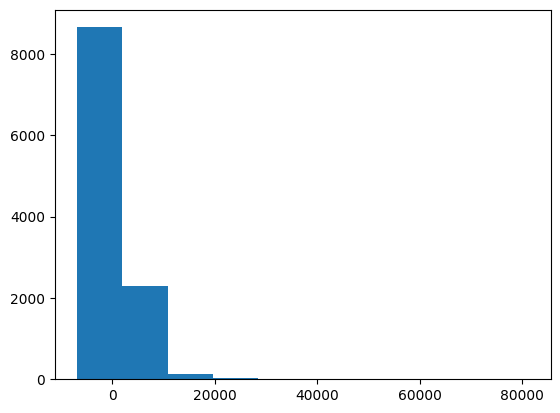

In [ ]:
plt.hist(df['balance']) # распределение логнормальное, поэтому будем использовать медиану

In [ ]:
#заполняем пропуски в соответствии с заявленным словарем
df = df.fillna(df['balance'].median())
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [ ]:
#Метод Тьюки (поиск выбросов)
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [ ]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


In [ ]:
df_c = cleaned.copy()
df_c

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

<Axes: xlabel='deposit', ylabel='count'>

4681

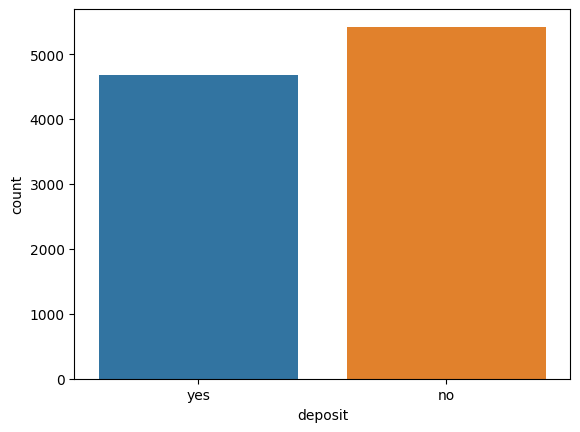

In [ ]:
# Проверяем сбалансированность данных
display(sns.countplot(data=df_c, x='deposit'))
df_c[df_c['deposit'] == 'yes'].shape[0]

In [ ]:
df_c.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000
mean,40.895487,807.331354,15.590657,368.777712,2.516924,51.307700,0.816112
std,11.735511,993.673452,8.441852,346.650712,2.707180,109.643031,2.243875
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,444.500000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1224.750000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4062.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


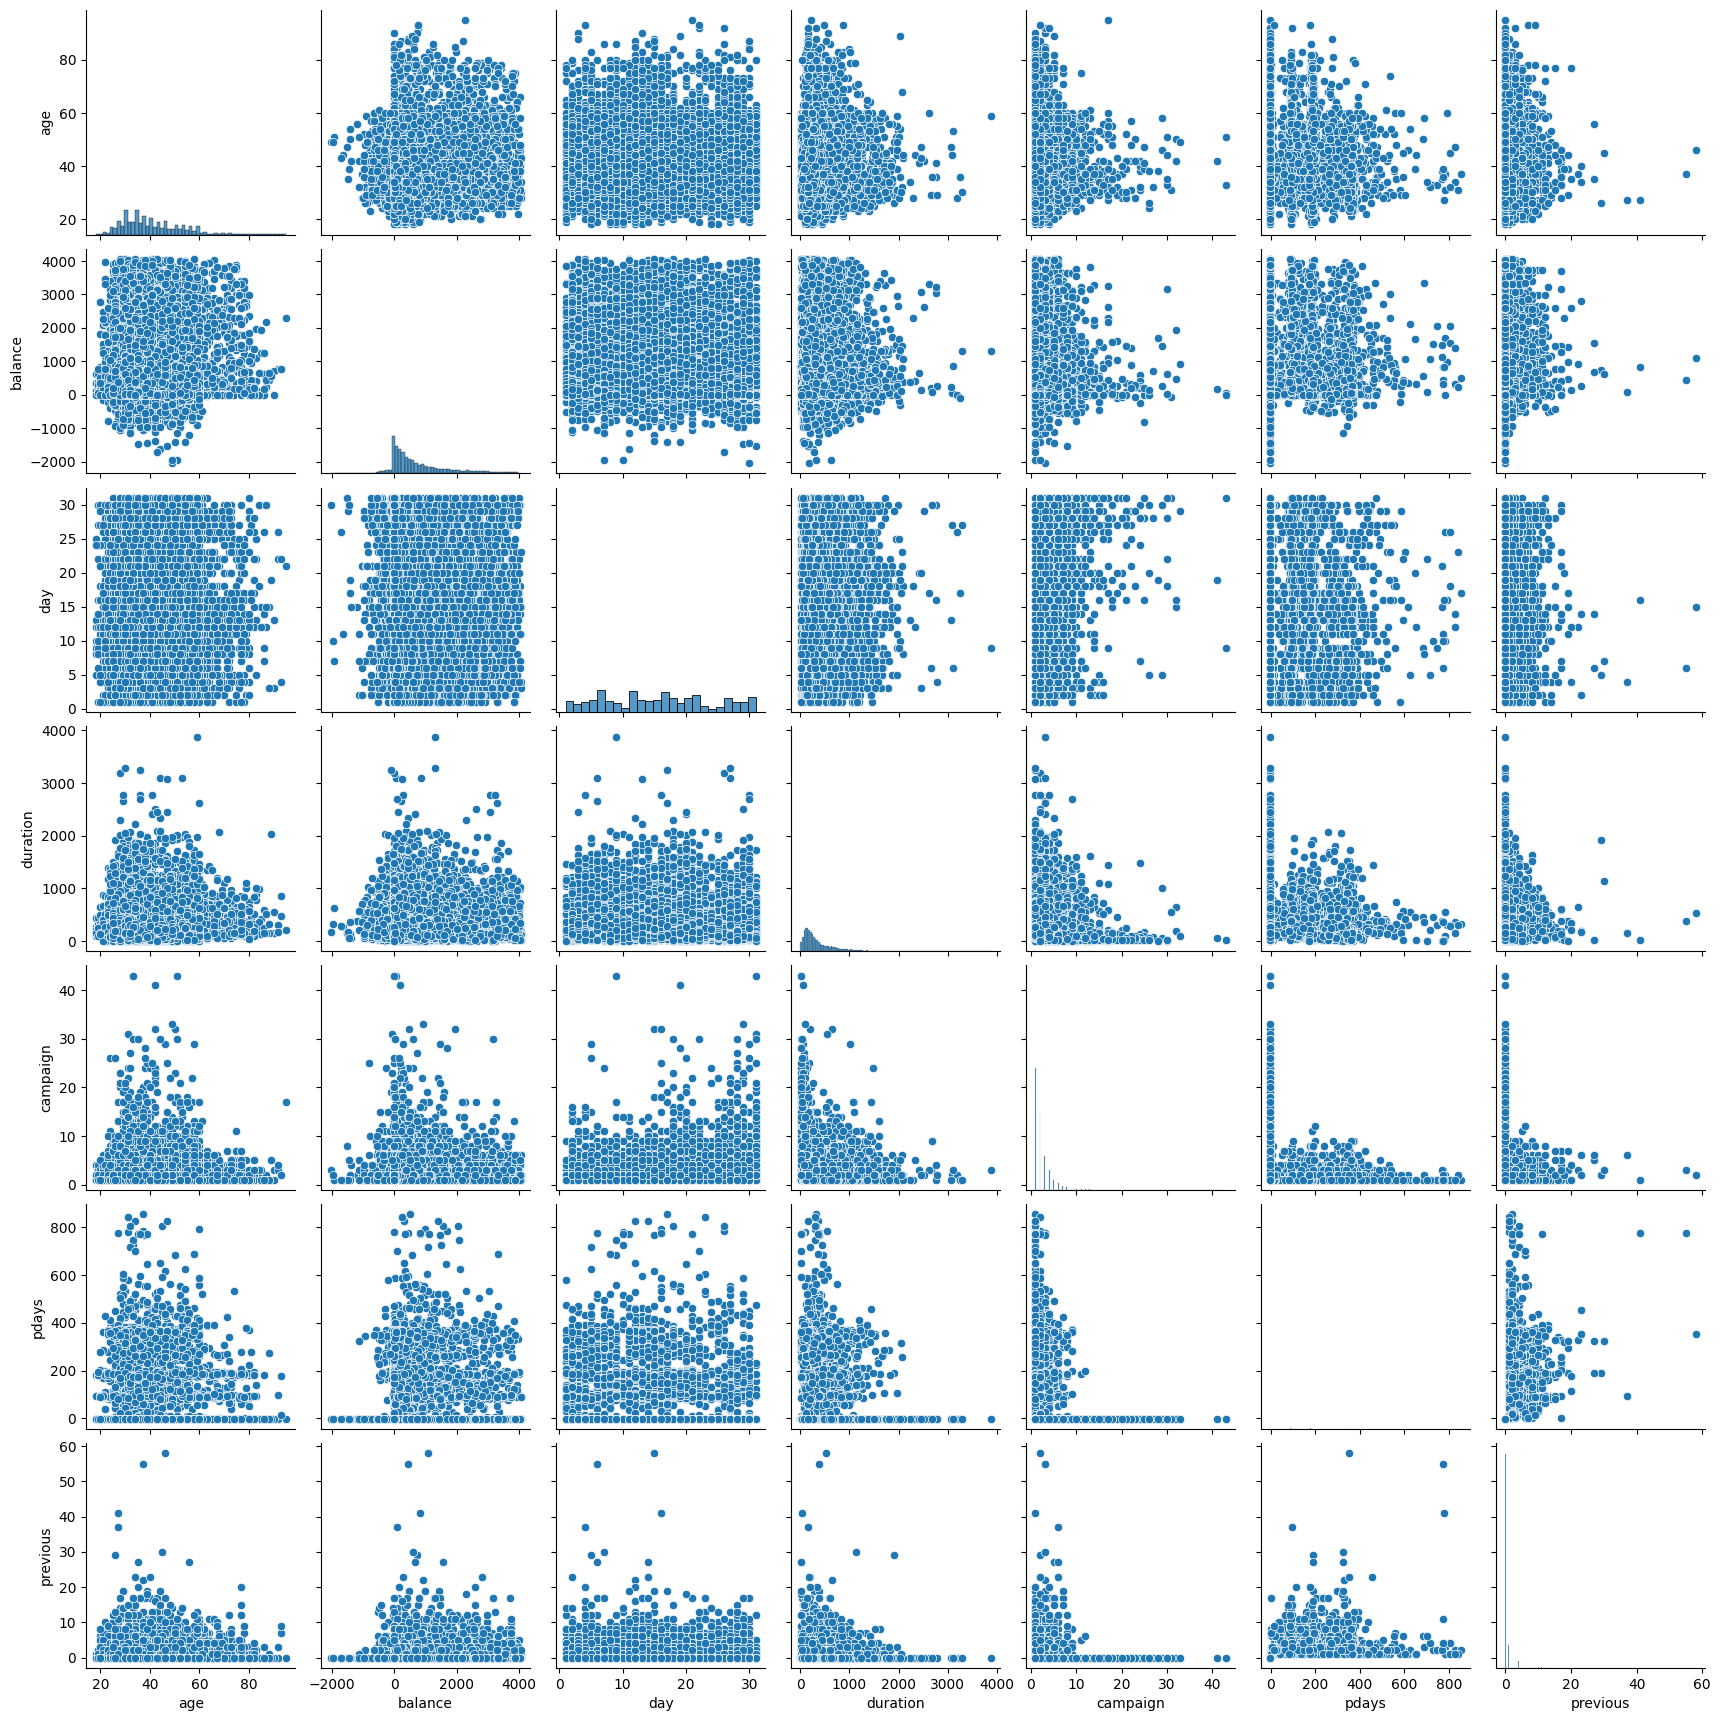

In [ ]:
sns.pairplot(df_c)

### Задания 4 и 5

Text(0, 0.5, 'Число объектов')

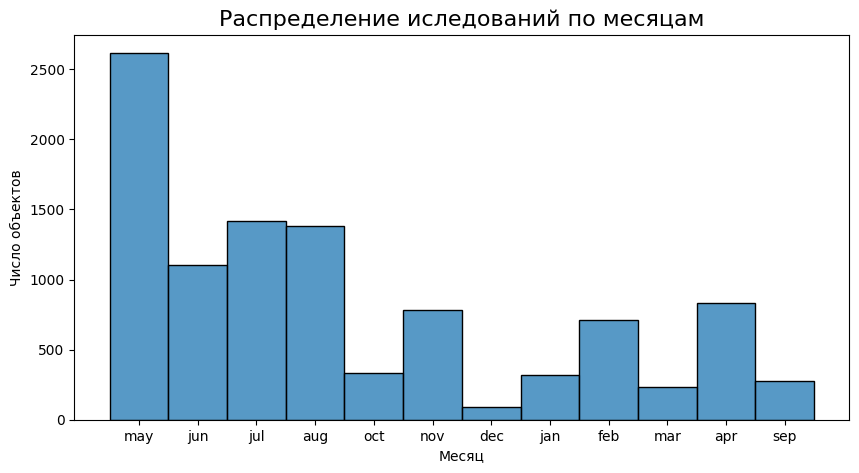

In [ ]:
# график когда проводилось иследование
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plt.subplots_adjust(hspace=.0)

histplot1 = sns.histplot(
    data=df_c,
    x='month',
    bins=30,

)
histplot1.set_title('Распределение иследований по месяцам', fontsize=16)
histplot1.set_xlabel('Месяц')
histplot1.set_ylabel('Число объектов')

Маркетинговая компания проводилась весь год.Больше всего иследований проводилось в мае





In [ ]:
df_c['job'].value_counts()

management       2314
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

Большое кол-во сфер занятости представлено среди клиентов банка.

In [ ]:
df_c.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          561
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь.

### Задание 7

In [ ]:
grouped_df_no  = df_c[df_c['deposit'] == 'no'].groupby(['month']).count()
grouped_df  = df_c.groupby(['month']).count()

# Цикл который вывод месяц и долю отказов от депозита
for i in range(12):
  print(grouped_df_no['deposit'].index[i], f"{round(grouped_df_no['deposit'].iloc[i] / grouped_df['deposit'].iloc[i]*100,2)} %")

apr 38.19 %
aug 55.96 %
dec 9.68 %
feb 45.56 %
jan 60.82 %
jul 58.96 %
jun 54.89 %
mar 10.13 %
may 67.85 %
nov 58.46 %
oct 18.51 %
sep 16.55 %


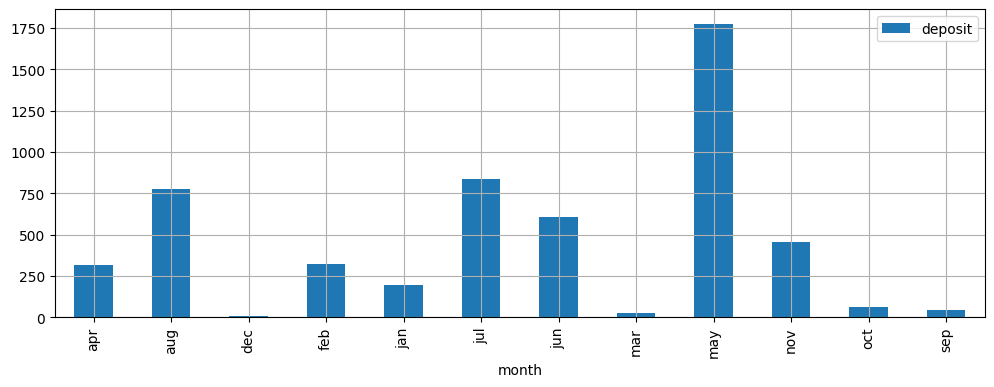

In [ ]:
grouped_df  = df_c[df_c['deposit'] == 'no'].groupby(['month']).count()
grouped_df['deposit'].plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    legend=True
);

Больше всего отказов было в мае

### Задание 8

In [ ]:
# функция распределяет клиентов по возрастных группам
def year_p (age):
  if age < 30:
    return 1
  elif age >= 30 and age <= 40:
    return 2
  elif age >= 41 and age <= 50:
    return 3
  elif age >= 51 and age <= 60:
    return 4
  elif age > 60:
    return 5

df_c['age_categories']  = df_c.apply(lambda x : year_p(x.age), axis=1)


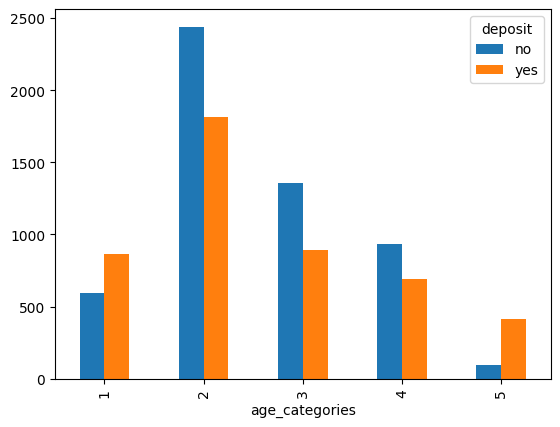

In [ ]:
df_group_age = df_c.groupby('age_categories')['deposit'].value_counts().unstack()
df_group_age.plot(kind='bar')
df_c = df_c.drop(['age'], axis = 1)


### Задания 9 и 10

<Axes: xlabel='marital'>

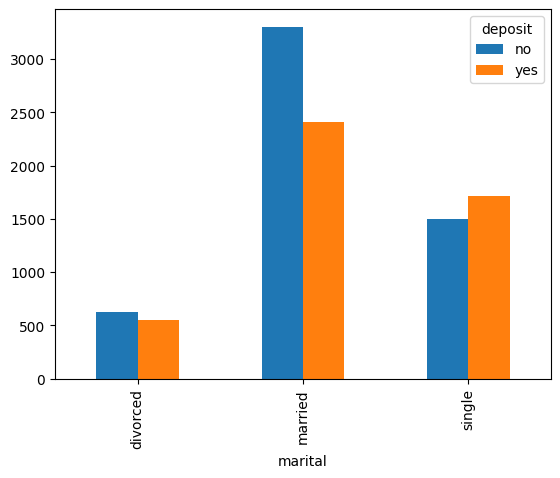

In [ ]:
#  визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса
df_group_marital = df_c.groupby('marital')['deposit'].value_counts().unstack()
df_group_marital.plot(kind='bar')

<Axes: xlabel='education'>

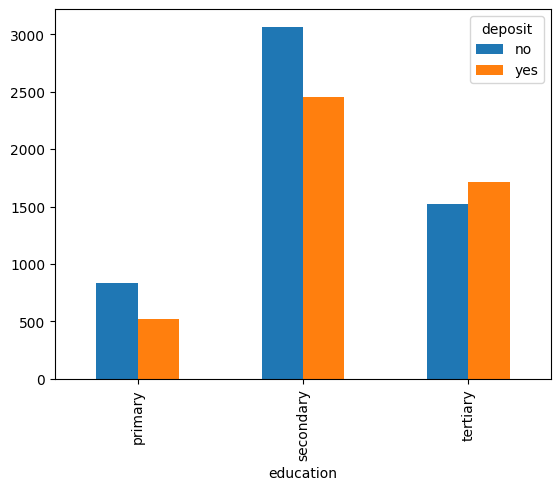

In [ ]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
df_group_education = df_c.groupby('education')['deposit'].value_counts().unstack()
df_group_education.plot(kind='bar')

<Axes: xlabel='job'>

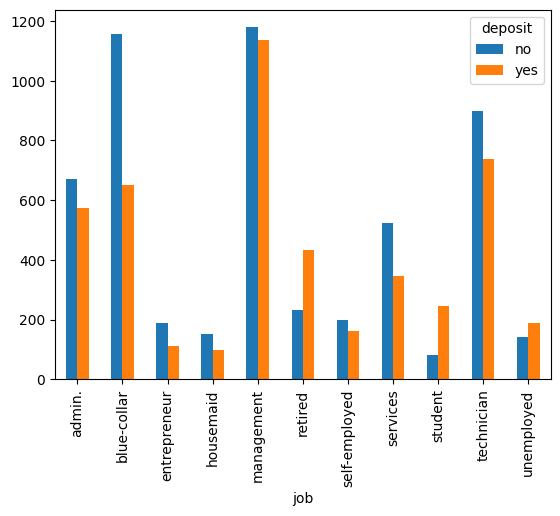

In [ ]:
#  визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df_group_job = df_c.groupby('job')['deposit'].value_counts().unstack()
df_group_job.plot(kind='bar')

### Задание 11

In [ ]:
df_c['count_dep']  = df_c['deposit'].apply(lambda x : 1 )
df_yes = df_c[df['deposit'] == 'yes'].copy()
df_no = df_c[df['deposit'] == 'no'].copy()


education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


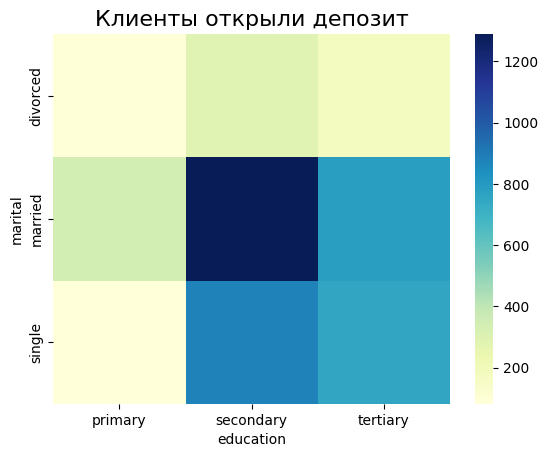

In [ ]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# которые открыли депозит

pivot_yes = df_yes.pivot_table(
    values='count_dep',
    columns='education',
    index='marital',
    aggfunc = 'count'
)

display(pivot_yes)

heatmap = sns.heatmap(data=pivot_yes, cmap='YlGnBu')
heatmap.set_title('Клиенты открыли депозит', fontsize=16);

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,831
single,100,866,531


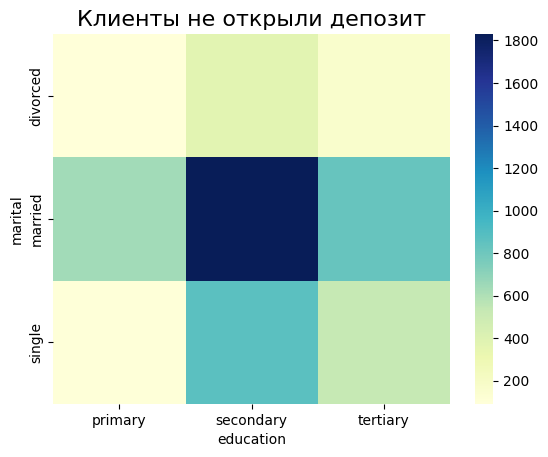

In [ ]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# которые не открыли депозит
pivot_no = df_no.pivot_table(
    values='count_dep',
    columns='education',
    index='marital',
    aggfunc = 'count'
)

display(pivot_no)

heatmap = sns.heatmap(data=pivot_no, cmap='YlGnBu')
heatmap.set_title('Клиенты не открыли депозит', fontsize=16);

In [ ]:
df_c = df_c.drop('count_dep', axis=1)

# Часть 3: преобразование данных

## Кодирование признака

In [ ]:
# Закодируем катигориальный признак образование
from sklearn.preprocessing  import LabelEncoder

lb = LabelEncoder()


lb.fit(df_c['education'])

print('категории:', lb.classes_)

df_c['education'] = lb.transform(df_c['education'])

df_c['education']

категории: ['primary' 'secondary' 'tertiary']


0        1
1        1
2        1
3        1
4        2
        ..
11157    0
11158    1
11159    1
11160    1
11161    1
Name: education, Length: 10104, dtype: int64

## Бинарное кодирование

In [ ]:
# преобразуйте бинарные переменные в представление из 0 и 1

df_c['deposit'] = df_c['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_c['housing'] = df_c['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_c['default'] = df_c['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_c['loan'] = df_c['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
df_c

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_categories
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,4
1,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,4
2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,3
3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,4
4,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,2
11158,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,2
11159,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,2
11160,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,3


## Дамми-переменные

In [ ]:
# создайте дамми-переменные
df_dummies = pd.get_dummies(df_c, columns=['job','marital','contact','month','poutcome'])
df_dummies


,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,2343.0,1,0,5,1042,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,45.0,0,0,5,1467,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,0,1270.0,1,0,5,1389,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,2476.0,1,0,5,579,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,2,0,184.0,0,0,5,673,2,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,0,1.0,1,0,20,257,1,-1,0,...,0,0,0,0,0,0,0,0,0,1
11158,1,0,733.0,0,0,16,83,4,-1,0,...,1,0,0,0,0,0,0,0,0,1
11159,1,0,29.0,0,0,19,156,2,-1,0,...,0,0,0,0,0,0,0,0,0,1
11160,1,0,0.0,0,1,8,9,2,172,5,...,0,0,1,0,0,0,1,0,0,0


## Корреляция

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
education,1.000000,-0.015677,0.042870,-0.094491,-0.052520,0.009042,-0.016744,-0.012396,0.023990,0.025305,...,-0.036462,0.052219,-0.104390,0.028742,0.027642,0.030869,0.019501,0.015132,0.070535,-0.068870
default,-0.015677,1.000000,-0.110946,0.009564,0.074782,0.018719,-0.008176,0.033417,-0.037311,-0.036599,...,0.019621,-0.020030,-0.001739,0.000540,-0.023933,-0.016979,-0.025424,-0.017926,-0.041514,0.055018
balance,0.042870,-0.110946,1.000000,-0.095312,-0.113020,-0.009854,0.026127,-0.043010,0.044824,0.060281,...,0.039888,0.043906,-0.098687,0.081998,0.057131,0.047921,0.030145,0.028198,0.073502,-0.084954
housing,-0.094491,0.009564,-0.095312,1.000000,0.072298,-0.022602,0.038601,0.006164,0.064032,-0.000276,...,-0.073101,-0.075937,0.432515,-0.000190,-0.092012,-0.086880,0.084913,0.009854,-0.134452,0.024265
loan,-0.052520,0.074782,-0.113020,0.072298,1.000000,0.019119,0.001436,0.033927,-0.030747,-0.020067,...,-0.014911,-0.041111,0.002846,0.017708,-0.032364,-0.046203,0.007574,-0.019298,-0.082111,0.059175
day,0.009042,0.018719,-0.009854,-0.022602,0.019119,1.000000,-0.016739,0.142215,-0.078716,-0.059718,...,-0.182050,-0.044310,-0.014511,0.056459,0.072172,-0.068752,-0.071084,-0.008816,-0.044381,0.085383
duration,-0.016744,-0.008176,0.026127,0.038601,0.001436,-0.016739,1.000000,-0.042487,-0.032945,-0.034182,...,-0.003097,-0.034658,0.008156,-0.015685,-0.012561,-0.012095,-0.039205,-0.009521,-0.026005,0.050406
campaign,-0.012396,0.033417,-0.043010,0.006164,0.033927,0.142215,-0.042487,1.000000,-0.105325,-0.052362,...,0.046797,-0.030561,-0.044509,-0.077284,-0.071505,-0.048659,-0.082578,-0.024835,-0.094235,0.135025
pdays,0.023990,-0.037311,0.044824,0.064032,-0.030747,-0.078716,-0.032945,-0.105325,1.000000,0.513689,...,-0.093519,0.024210,0.028499,-0.007319,0.079858,0.110932,0.608690,0.338094,0.326271,-0.824014
previous,0.025305,-0.036599,0.060281,-0.000276,-0.020067,-0.059718,-0.034182,-0.052362,0.513689,1.000000,...,-0.050050,0.025234,-0.025169,0.019738,0.055087,0.099806,0.347796,0.318905,0.329001,-0.628357


<Axes: >

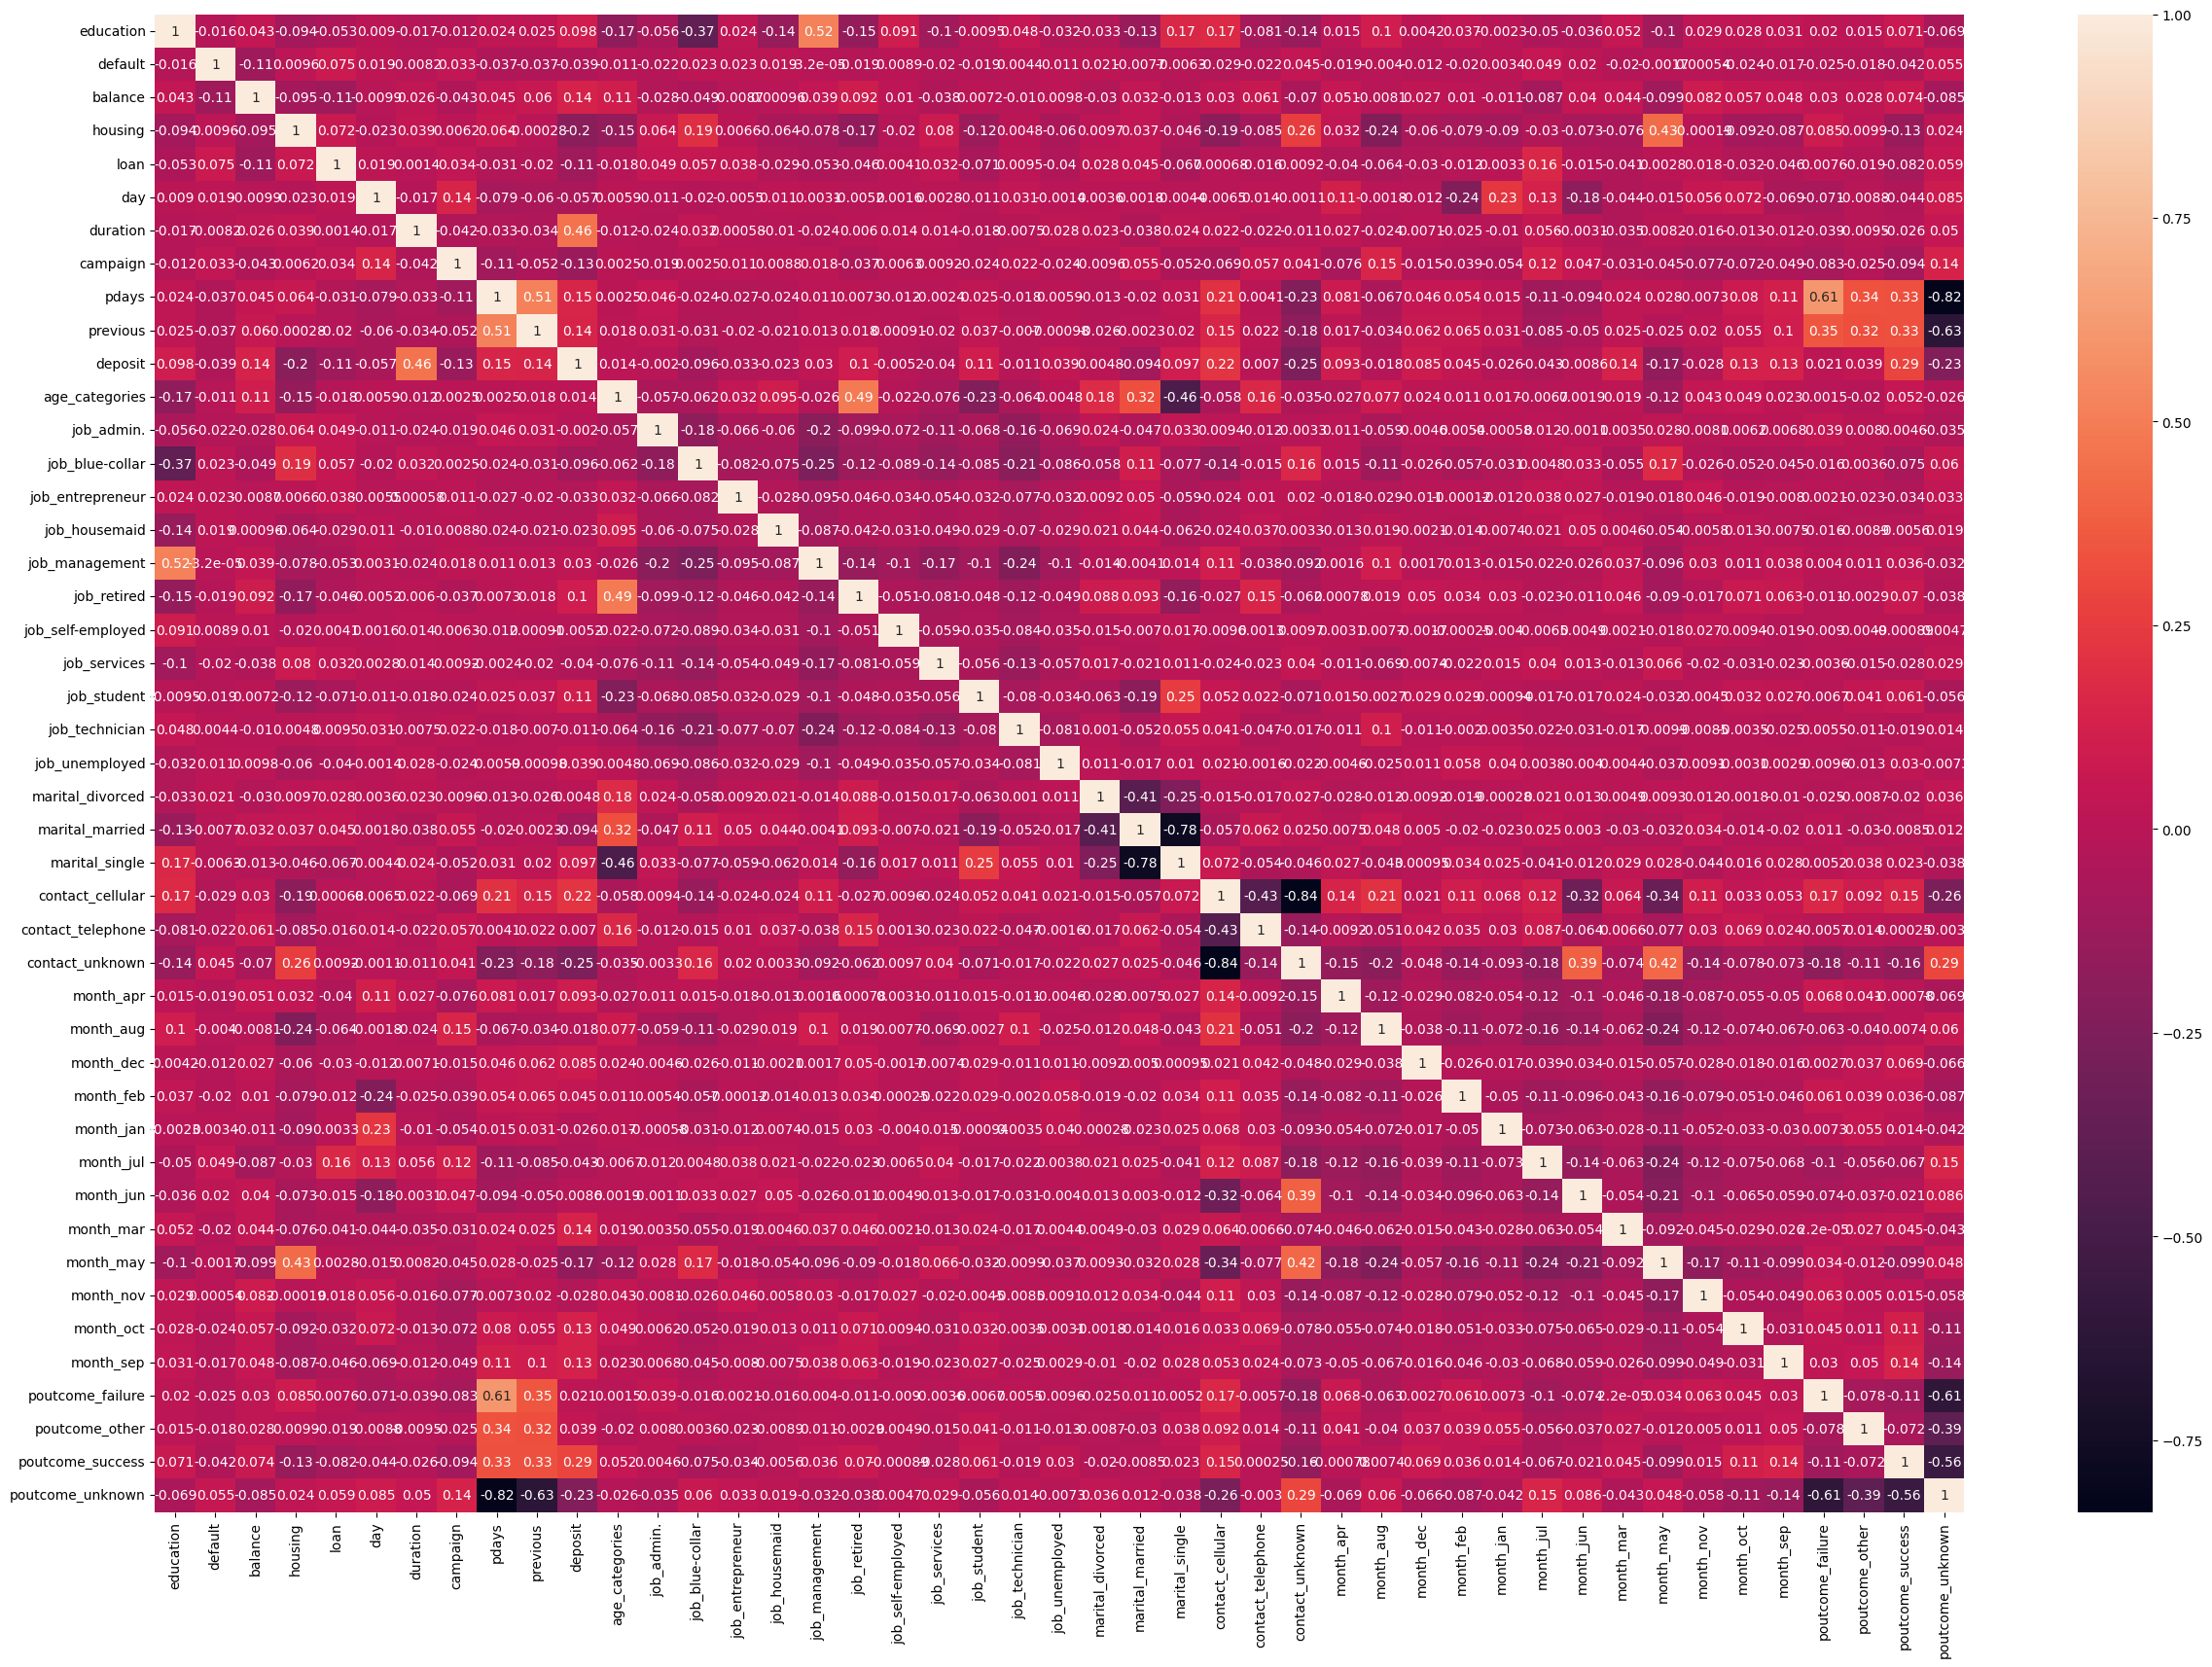

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
display(df_dummies.corr())

plt.figure(figsize = (30, 20))
sns.heatmap(df_dummies.corr(), annot = True) # тепловая карта с коэф

## Разбиение выборки

In [ ]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
print(X_test.shape)
print(X_train.shape)

(3335, 44)
(6769, 44)


## Отбор лучших признаков

In [ ]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [ ]:
new_df_train = X_train.iloc[:,selector.get_support()]
new_df_test = X_test.iloc[:,selector.get_support()]

## Нормализация

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(new_df_train)
X_train_scaled = scaler.transform(new_df_train)
X_test_scaled = scaler.transform(new_df_test)

In [ ]:
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scaled = pd.DataFrame(X_train_scaled, columns = list(new_df_train.columns))
X_test_scaled = pd.DataFrame(X_test_scaled, columns = list(new_df_test.columns))
display(X_train_scaled)
display(X_test_scaled)


,balance,housing,loan,duration,campaign,pdays,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.341300,0.0,0.0,0.015210,0.000000,0.226901,0.017241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.346702,0.0,1.0,0.075793,0.000000,0.240936,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.405795,1.0,0.0,0.026038,0.023810,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.408086,0.0,0.0,0.034803,0.000000,0.120468,0.086207,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.571779,0.0,0.0,0.025264,0.000000,0.138012,0.137931,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,0.371747,0.0,1.0,0.028100,0.000000,0.239766,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6765,0.923228,1.0,0.0,0.078371,0.023810,0.212865,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6766,0.737109,1.0,0.0,0.184068,0.047619,0.308772,0.034483,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6767,0.369619,0.0,0.0,0.155452,0.023810,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,balance,housing,loan,duration,campaign,pdays,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.360779,0.0,0.0,0.074246,0.000000,0.109942,0.034483,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.338353,0.0,0.0,0.052591,0.047619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.364053,0.0,0.0,0.042537,0.071429,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.543297,0.0,0.0,0.059294,0.047619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.548862,0.0,0.0,0.056200,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,0.418399,0.0,0.0,0.097448,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3331,0.414798,0.0,0.0,0.019850,0.023810,0.219883,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3332,0.606973,1.0,0.0,0.030420,0.119048,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3333,0.549517,0.0,0.0,0.082753,0.047619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

## Логистическая регрессия

In [ ]:

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_train_pred_1 = log_reg.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_1)))
print('accuracy_score на обучающем наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_1)))

y_test_pred_1 = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_1)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_1)))

f1_score на обучающем наборе: 0.79
accuracy_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.78
accuracy_score на тестовом наборе: 0.81


## Дерево решений

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_tree = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
    max_depth = 6
)
#Обучаем дерево решений по алгоритму CART
dt_clf_tree.fit(X_train_scaled, y_train)
y_train_pred_2 = dt_clf_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_2)))
print('accuracy_score на обучающем наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_2)))

#Делаем предсказание класса для всего набора данных
y_test_pred_2  = dt_clf_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_2)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_2)))


f1_score на обучающем наборе: 0.79
accuracy_score на обучающем наборе: 0.81
f1_score на тестовом наборе: 0.78
accuracy_score на тестовом наборе: 0.80


## Подбор гиперпараметров

In [ ]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 15, dtype=int)),
              'min_samples_split' : list(np.linspace(1, 30, 15, dtype=int)),
              'criterion':['entropy','gini']

              }

random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_iter = 50,
    n_jobs = -1
)
%time random_search_tree.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: user 299 ms, sys: 64.9 ms, total: 364 ms
Wall time: 4.77 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'min_samples_split': 9, 'min_samples_leaf': 47, 'max_depth': 9, 'criterion': 'gini'}


Наилучшие значения гиперпараметров:

min_samples_split: 17

min_samples_leaf: 45

max_depth: 30

criterion: gini

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_tree = tree.DecisionTreeClassifier(
    criterion='gini', #критерий информативности
    random_state=42, #генератор случайных чисел
    max_depth = 30,
    min_samples_leaf = 45
)
#Обучаем дерево решений по алгоритму CART
dt_clf_tree.fit(X_train_scaled, y_train)
y_train_pred_3 = dt_clf_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_3)))
print('accuracy_score на обучающем наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_3)))

#Делаем предсказание класса для всего набора данных
y_test_pred_3  = dt_clf_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_3)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_3)))


f1_score на обучающем наборе: 0.81
accuracy_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.79
accuracy_score на тестовом наборе: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

## Случайный лес

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    criterion='gini', #критерий информативности
    random_state=42, #генератор случайных чисел
    max_depth = 10,
    n_estimators = 100,
    min_samples_leaf = 5
)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики
y_train_pred_4 = rf.predict(X_train_scaled)
print('f1_score на обучающем наборе : {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_4)))
y_test_pred_4 = rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_4)))

f1_score на обучающем наборе : 0.84
f1_score на тестовом наборе: 0.82


In [ ]:
print(metrics.classification_report(y_test, y_test_pred_4))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Градиентный бустинг

In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    min_samples_leaf = 5,
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_test_pred_5 = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_test_pred_5))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Стекинг 3 моделей

In [ ]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', LogisticRegression(max_iter = 1000)),
    ('dtс',  DecisionTreeClassifier(
    criterion='gini', #критерий информативности
    random_state=42, #генератор случайных чисел
    max_depth = 30,
    min_samples_leaf = 45)),
    ('gb', GradientBoostingClassifier(
    min_samples_leaf = 5,
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator = LogisticRegression(max_iter = 1000)
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
y_test_pred_6 = reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred_6))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.82      0.82      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Наиболее важные признаки

<Axes: >

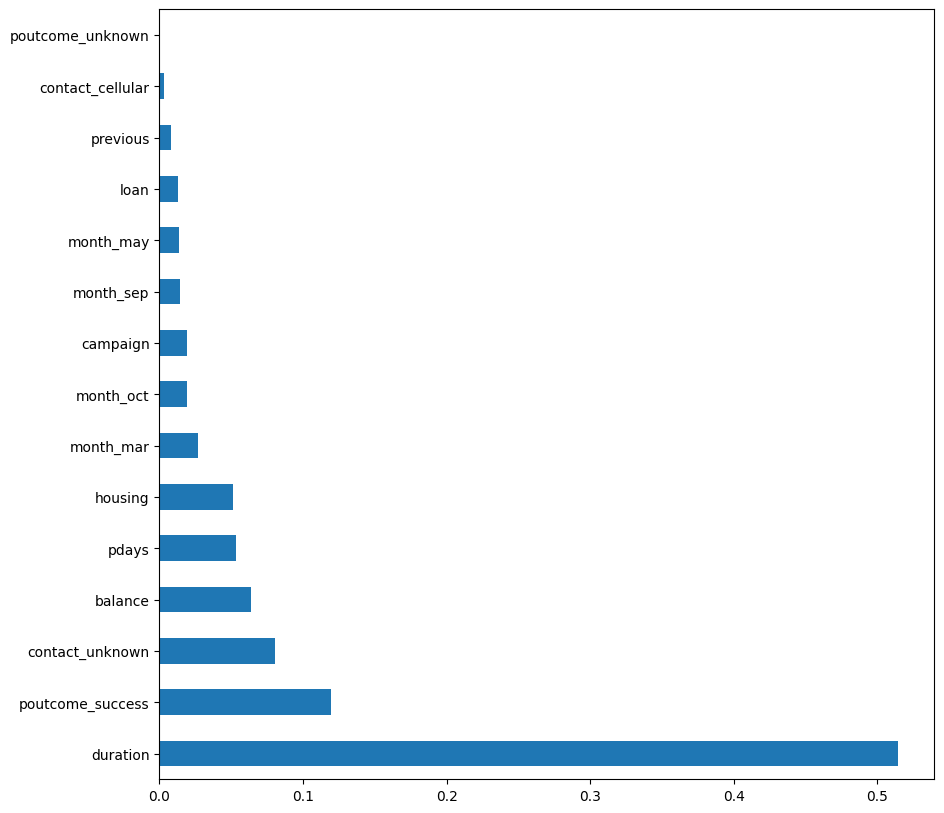

In [ ]:
# График, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
X_test_scaled_c = X_test_scaled.copy()
X_train_scaled_c = X_train_scaled.copy()

In [ ]:
X_train_scaled_c = X_train_scaled_c.drop(['poutcome_unknown'], axis = 1)
X_test_scaled_c = X_test_scaled_c.drop(['poutcome_unknown'], axis = 1)


In [ ]:
X_train_scaled_c = X_train_scaled_c.drop(['contact_cellular'], axis = 1)
X_test_scaled_c = X_test_scaled_c.drop(['contact_cellular'], axis = 1)

In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    min_samples_leaf = 5,
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled_c , y_train)
# Формируем предсказание для тестовой выборки
y_test_pred_7 = gb.predict(X_test_scaled_c )
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_test_pred_7))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

